# Backtest Portfolio Strategy 
This notebook demonstrates how to backtest a portfolio strategy using the `bt` library in Python. The strategy is based on the Markowitz Mean-Variance Optimization approach, which aims to maximize returns while minimizing risk.

### **Step 1: Import Libraries** 

In [1]:
# UDFs
from py.utils import load_and_filter_data

# Data manipulation libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Plotting libraries
import matplotlib.pyplot as plt

# Backtesting library
import bt

### **Step 2: Define Parameters**

#### Date Range

In [2]:
# Define the date range
end_date = (datetime.today() - BDay(1)).to_pydatetime()  # Subtract 1 business day
start_date = end_date - timedelta(days=5*365)

# Print the date range
days_difference = (end_date - start_date).days
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Time span: {days_difference} days ({days_difference/365:.2f} years)")

Date Range: 2020-05-29 to 2025-05-28
Time span: 1825 days (5.00 years)


#### Risk-free rate (T-bill, %)

In [3]:
daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
# risk_free_rate = .0433
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100

last_risk_free_df = daily_risk_free_df \
    .sort_index(axis=0, ascending=False) \
    .head(1) \
    .reset_index() \
    .melt(id_vars='Date', value_vars=['^IRX'])

last_risk_free_df.set_index('Date', inplace=True)
last_risk_free_df.rename(columns={'value': 'Close', 'variable': 'Ticker'}, inplace=True)

print("Risk-Free Rate:", risk_free_rate, "-- 13 WEEK TREASURY BILL (^IRX)")

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Risk-Free Rate: 0.042249999999999996 -- 13 WEEK TREASURY BILL (^IRX)


#### Portfolio Data

In [4]:
output_file = f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
portfolio_df = pd.read_excel(output_file, sheet_name='equity')
tickers = portfolio_df['Ticker'].unique()
display(portfolio_df)

,Ticker,Date,Name,Sector,Industry,Country,Website,Market Cap,Enterprise Value,Float Shares,...,52W High,52W Low,50 Day Avg,200 Day Avg,Short Ratio,Short % of Float,Weight,Expected Return,Standard Deviation,Sharpe Ratio
0,PH,2025-05-29,Parker-Hannifin Corporation,Industrials,Specialty Industrial Machinery,United States,https://investors.parker.com,84806778880,94111514624,127309059,...,718.44,488.45,614.44,637.45,2.02,0.01,0.270121,0.256555,0.301802,0.850078
1,TMUS,2025-05-29,"T-Mobile US, Inc.",Communication Services,Telecom Services,United States,https://www.t-mobile.com,271662088192,383910346752,452736028,...,276.49,168.47,251.97,232.51,3.11,0.03,0.241551,0.165114,0.242144,0.681881
2,MMC,2025-05-29,"Marsh & McLennan Companies, Inc.",Financial Services,Insurance Brokers,United States,https://www.marshmclennan.com,113561485312,134108872704,491821141,...,248.00,201.84,229.53,225.16,2.62,0.01,0.220877,0.160872,0.193348,0.832035
3,GS,2025-05-29,"The Goldman Sachs Group, Inc.",Financial Services,Capital Markets,United States,https://www.goldmansachs.com,184569462784,-97711923200,291018731,...,672.19,437.37,552.81,557.96,2.40,0.02,0.168120,0.228153,0.286993,0.794977
4,SO,2025-05-29,The Southern Company,Utilities,Utilities - Regulated Electric,United States,https://www.southerncompany.com,97311801344,168135639040,1095702946,...,94.45,76.87,89.90,87.90,5.08,0.02,0.099331,0.109371,0.194849,0.561314


#### Asset Weights

In [5]:
weights_df = portfolio_df[['Ticker', 'Weight']]
weights = dict(zip(weights_df['Ticker'], weights_df['Weight']))
weights

{'PH': 0.2701211596213668,
 'TMUS': 0.2415512353701523,
 'MMC': 0.2208771700508186,
 'GS': 0.168119518059237,
 'SO': 0.0993309168984251}

#### **Step 3: Import Stock Data**

In [6]:
data = load_and_filter_data('data/daily_stock_quotes.csv', tickers, start_date, end_date)
data.head()

Found 5 of 5 tickers in data/daily_stock_quotes.csv
Missing tickers: []


,GS,MMC,PH,SO,TMUS
Date,,,,,
2020-06-01,178.21,99.50,170.51,47.88,97.50
2020-06-02,181.96,100.73,172.55,48.13,98.19
2020-06-03,187.70,101.86,182.95,48.72,98.97
2020-06-04,191.48,101.39,183.47,48.09,97.96
2020-06-05,194.25,103.97,182.15,48.51,98.90


#### **Step 4: Create & Backtest Strategy**

In [7]:
# Strategy 1 - Monthly rebalancing
strat1 = bt.Strategy('Markowitz (Mean Variance) Strategy', 
                          [bt.algos.RunMonthly(),                   
                           bt.algos.SelectAll(),
                           bt.algos.WeighSpecified(**weights),      
                           bt.algos.Rebalance()])     

# Create backtests
test1 = bt.Backtest(strat1, data)

#### **Step 5: Run Backtest**

In [10]:
res1 = bt.run(test1)
res1.set_riskfree_rate(risk_free_rate)
res1.display()
# res1.get_transactions().head()

100%|██████████| 1/1 [00:00<00:00, 9892.23it/s]

Stat                 Markowitz (Mean Variance) Strategy
-------------------  ------------------------------------
Start                2020-05-31
End                  2025-05-28
Risk-free rate       4.22%

Total Return         201.08%
Daily Sharpe         1.09
Daily Sortino        1.81
CAGR                 24.71%
Max Drawdown         -15.16%
Calmar Ratio         1.63

MTD                  4.14%
3m                   -3.51%
6m                   -0.93%
YTD                  8.36%
1Y                   30.31%
3Y (ann.)            25.03%
5Y (ann.)            24.71%
10Y (ann.)           -
Since Incep. (ann.)  24.71%

Daily Sharpe         1.09
Daily Sortino        1.81
Daily Mean (ann.)    23.76%
Daily Vol (ann.)     17.98%
Daily Skew           -0.17
Daily Kurt           4.33
Best Day             7.28%
Worst Day            -6.66%

Monthly Sharpe       1.07
Monthly Sortino      2.45
Monthly Mean (ann.)  23.86%
Monthly Vol (ann.)   18.41%
Monthly Skew         0.46
Monthly Kurt         1.00
Best M

#### **Step 6: Visualize Backtest Results**

Text(0, 0.5, 'Frequency')

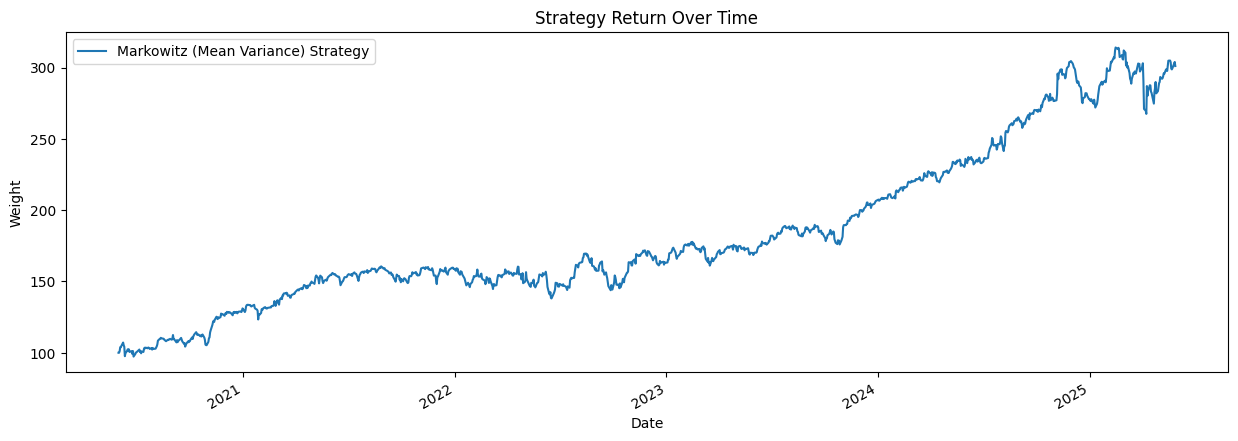

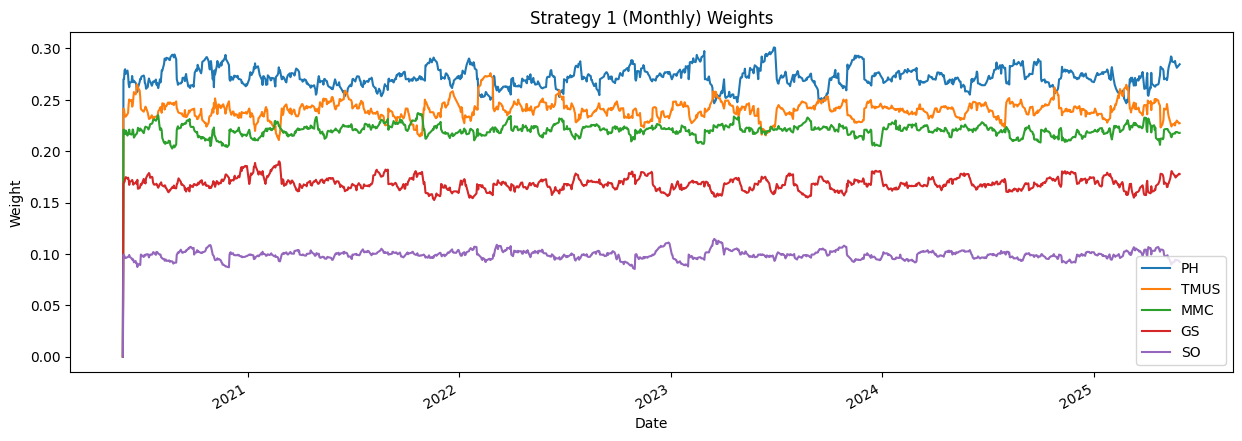

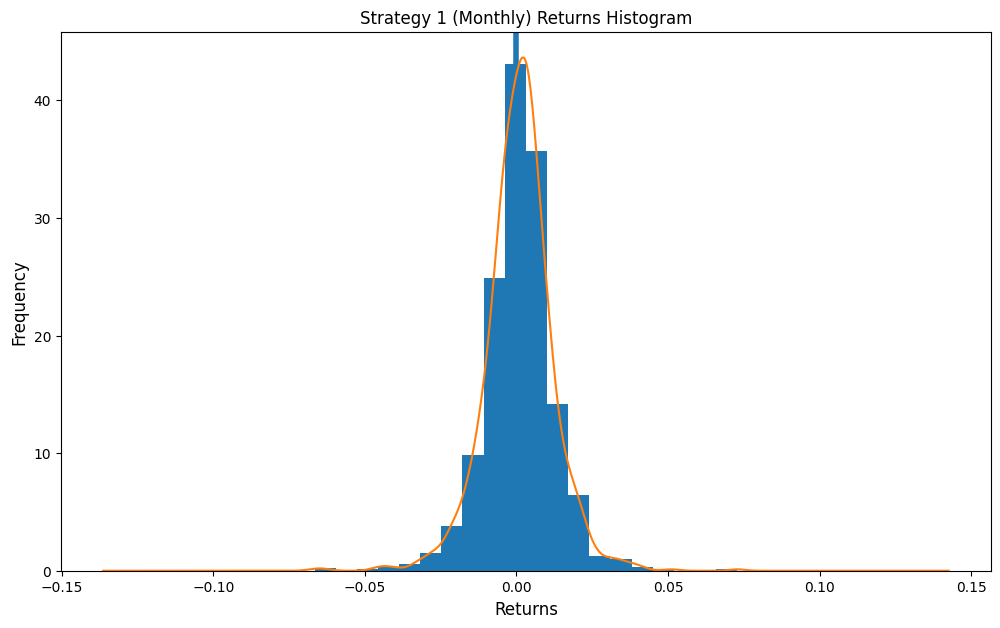

In [9]:
res1.plot(title="Strategy Return Over Time", xlabel="Date", ylabel="Weight")

# Plot weights from the strategies to illustrate the different weighting schemes
res1.plot_security_weights(title="Strategy 1 (Monthly) Weights", xlabel="Date", ylabel="Weight")

# Plot histograms and set labels manually
res1.plot_histogram(figsize=(12, 7), title="Strategy 1 (Monthly) Returns Histogram")
plt.xlabel("Returns", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

#### **Step 7: Benchmark Comparison**